In [23]:
import torch
import pickle
import torchvision
from torchvision import transforms
import torchvision.datasets as dset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from model import Siamese, AlexNet_Siamese
import time
import numpy as np
import sys
from collections import deque
import os
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import random

In [24]:
class DecomTest(Dataset):

    def __init__(self, test_pair_info, transform=None, times=200, way=20):
        np.random.seed(1)
        super(DecomTest, self).__init__()
        self.transform = transform
        self.times = times
        self.way = way
        self.pair_data, self.num_pairs = self.loadToMem(test_pair_info)

    def loadToMem(self, test_pair_info):
        print("begin loading training dataset to memory")
        agrees = [0, 90, 180, 270]
        num = 0
        pair_data = pd.read_json(test_pair_info, lines=True)
        print("finish loading training dataset to memory")
        return pair_data, pair_data.shape[0]


    def __len__(self):
        return self.times * self.way

    def __getitem__(self, index):
        label = None
        image1 = None
        image2 = None
        idx = random.randint(0, self.num_pairs - 1)
        
        name1 = self.pair_data.iloc[idx]['fpath_img'][0]
        name2 = self.pair_data.iloc[idx]['fpath_img'][1]
        image1 = Image.open(name1).convert('L')
        image2 = Image.open(name2).convert('L')
        label = self.pair_data.iloc[idx]['iou']
        if label > 0.6:
            label = 1
        else:
            label = 0

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, image2, torch.from_numpy(np.array([label], dtype=np.float32)), name1, name2

In [25]:
net = AlexNet_Siamese()
net.load_state_dict(torch.load("models_decom/model.pt"))
net.eval()

AlexNet_Siamese(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (liner): Sequential(
    (0): Linear(in_features=24576, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)


In [26]:
test_path = "/data/sara/DecompositionFeatureSegmentation/data/bodyparts_csv/siamese_test.odgt"

In [27]:
data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor()
    ])

#        transforms.RandomAffine(15),

In [30]:
testSet = DecomTest(test_path, transform=data_transforms, times = 10, way = 1)
testLoader = DataLoader(testSet, batch_size=1, shuffle=False)


begin loading training dataset to memory
finish loading training dataset to memory


/usb/seq_data_for_mit_code/04000722.52.JPG /usb/seq_data_for_mit_code/3f200406.10.JPG 0.0


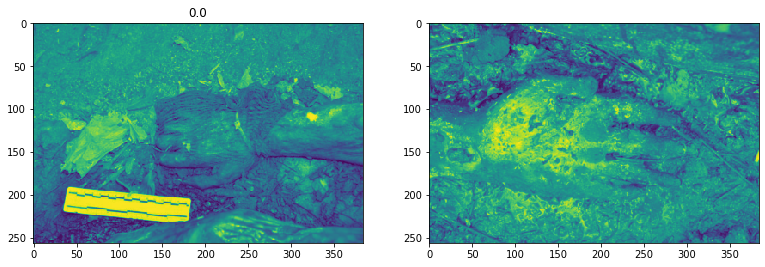

/usb/seq_data_for_mit_code/36800513.03.JPG /usb/seq_data_for_mit_code/a4800512.12.JPG 0.0


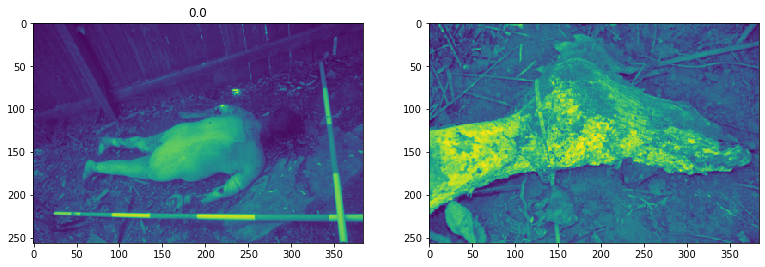

/usb/seq_data_for_mit_code/60810325.26.JPG /usb/seq_data_for_mit_code/65b01005.48.JPG 1.0


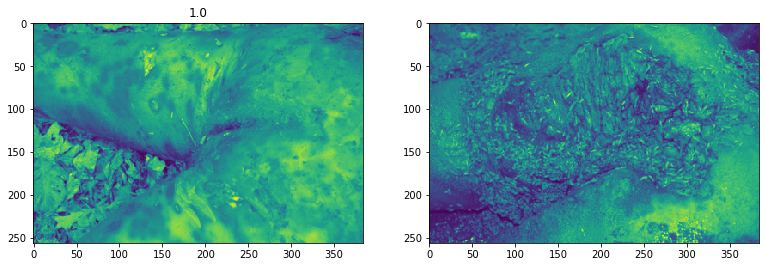

/usb/seq_data_for_mit_code/04000717.61.JPG /usb/seq_data_for_mit_code/9f400325.27.JPG 1.0


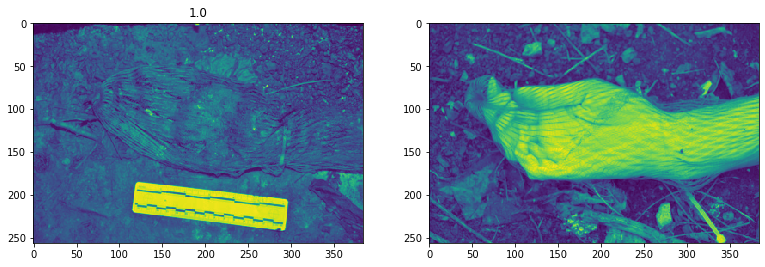

/usb/seq_data_for_mit_code/07b00122.21.JPG /usb/seq_data_for_mit_code/07b00122.22.JPG 1.0


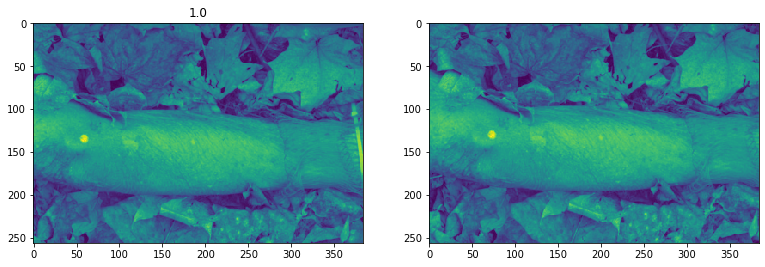

/usb/seq_data_for_mit_code/07b00122.38.JPG /usb/seq_data_for_mit_code/b5700307.47.JPG 1.0


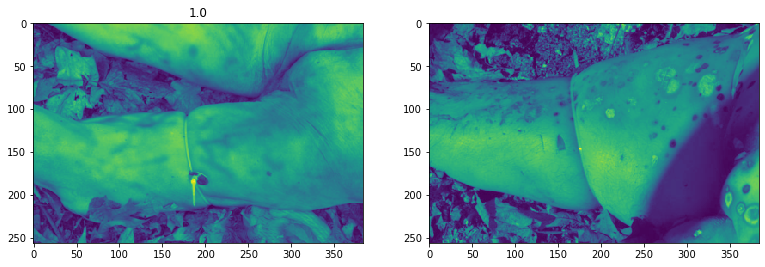

/usb/seq_data_for_mit_code/a8b00722.05.JPG /usb/seq_data_for_mit_code/68c00710.02.JPG 0.0


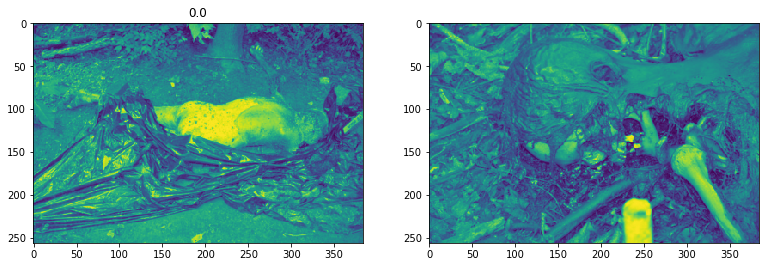

/usb/seq_data_for_mit_code/d7700707.29.JPG /usb/seq_data_for_mit_code/d8510109.38.JPG 0.0


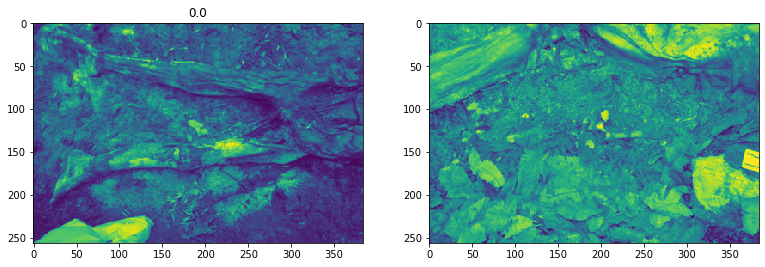

/usb/seq_data_for_mit_code/36800513.03.JPG /usb/seq_data_for_mit_code/a4800512.12.JPG 0.0


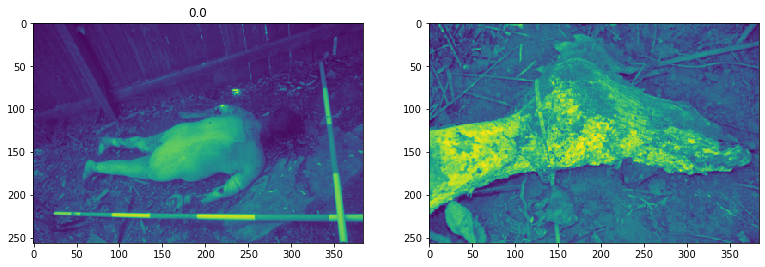

/usb/seq_data_for_mit_code/36800513.23.JPG /usb/seq_data_for_mit_code/07b00122.17.JPG 1.0


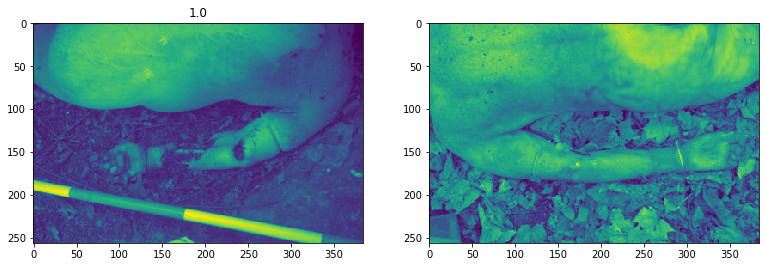

In [34]:
for _, (test1, test2, l, name1, name2) in enumerate(testLoader, 1):

    test1, test2 = test1, test2
    test1, test2 = Variable(test1), Variable(test2)
    output = net.forward(test1, test2)
    output_sigm = torch.sigmoid(output) 
    output_round = torch.round(output_sigm) # convert the prediction to 0 and 1
    preds = output_round.data.cpu().numpy()
    print(name1[0], name2[0], preds[0][0])
    fig, axs = plt.subplots(1,2,figsize=(13, 7))
    axs[0].imshow(test1[0][0])
    axs[0].set_title(str(preds[0][0]))
    axs[1].imshow(test2[0][0])
    plt.show()
    

In [32]:
preds[0][0]

1.0